### Constant Range

策略：初始的时候选定一个价格范围，之后就不再调整。

根据初始的时候如何选择价格范围，又可以分为很多策略：

    1. 以当前价格为中心，选定一个固定长度的价格范围(这个策略相当于part3_activeAdjustment在首次提供之后不再调整)

    2. 参考池子内流动性的分布图，以分布最多的价格为中心，选择一个固定长度的价格范围
        如何获得池子内流动性的分布图？
            暴力的算法是获取池子里所有的mint和burn事件，加总到每一个tick上

    3. 计算出池子价格的时间加权价格，以当前的时间加权价格为中心，选择一个固定长度的价格范围

    4. 基于布林带
        选择布林带的上轨线作为价格上限，下轨线作为价格下限，作为价格范围。
    等等

In [159]:
import sys
sys.path.append("..") 
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from importlib import reload
from poolData import swapData
from utils import utils
reload(swapData)
reload(utils)

query = swapData.SwapDataQuery()
utils = utils.utils()

* * *
### 1 以当前价格为中心，选择固定长度的tick range
    直接在part3里改，不放在这里了

### 2 以流动性最密集价格为中心，选择固定长度的tick range


In [160]:
begin = datetime(2023, 3, 19)
# begin的时候，区块高度差不多是16868192
block = 16868192

In [161]:
variables = { "pool": 1203, "timestamp_gt": 3290}
variables

{'pool': 1203, 'timestamp_gt': 3290}

In [162]:
variables["pool"]


1203

In [163]:
# 先计算流动性的分布，还好the graph支持了查询一个tick的liquidity，不用自己暴力算了
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
tick_data = query.query_tick_liquidities(poolAddress=pool_id, block=block)
tick_data

this is the cursor: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#197060
this is the cursor: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#207030
this is the cursor: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95820


,id,liquidityGross
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100,100
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310,17093244380199
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340,2266789968
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360,2273693713
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390,44739669244
...,...,...
2715,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-88...,2128374373681327
2716,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#92110,25157895928880
2717,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-92110,398290794261
2718,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95810,830863045158786350


In [164]:
tick_data 

,id,liquidityGross
0,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#100,100
1,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#102310,17093244380199
2,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108340,2266789968
3,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108360,2273693713
4,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#108390,44739669244
...,...,...
2715,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-88...,2128374373681327
2716,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#92110,25157895928880
2717,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#-92110,398290794261
2718,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640#95810,830863045158786350


In [166]:
# 处理一下id，#后的数字应该是tick index
tick_data["tick_index"] = tick_data["id"].str.split("#").str.get(1)
tick_data["tick_index"] = tick_data["tick_index"].astype(int)
tick_data["liquidityGross"] = tick_data["liquidityGross"].astype(float)
tick_data.dropna()
tick_data = tick_data[["tick_index", "liquidityGross"]]

In [167]:
tick_data.sort_values("tick_index", inplace=False)

,tick_index,liquidityGross
2715,-887270,2.128374e+15
2713,-875030,0.000000e+00
2684,-460540,0.000000e+00
2587,-332730,0.000000e+00
1582,-202860,0.000000e+00
...,...,...
2685,575680,0.000000e+00
2688,644760,0.000000e+00
2696,736860,0.000000e+00
2701,759890,3.982908e+11


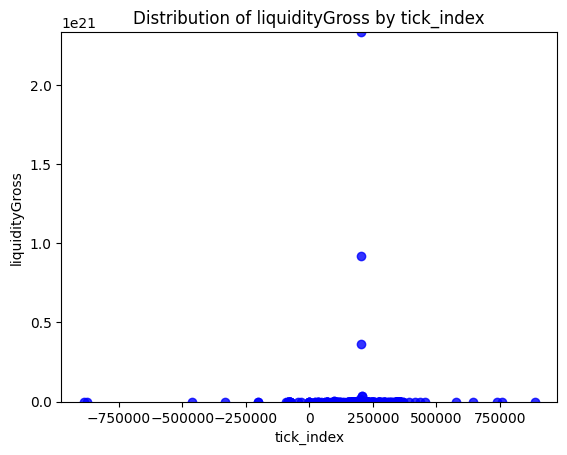

In [170]:
# 设置柱状图的颜色和透明度
color = 'blue'
alpha = 0.8

# 绘制柱状图
plt.scatter(tick_data['tick_index'], tick_data['liquidityGross'], color=color, alpha=alpha)

# 设置横纵坐标的标签和标题
plt.xlabel('tick_index')
plt.ylabel('liquidityGross')
plt.title('Distribution of liquidityGross by tick_index')

# 设置y轴的刻度范围
plt.ylim([0, max(tick_data['liquidityGross'])])

# 显示图形
plt.show()
# todo 分布图画好看点


In [191]:
grouped_df = tick_data.groupby(['tick_index'])['liquidityGross'].sum().reset_index()
grouped_df = grouped_df.sort_values(by="liquidityGross", ascending=False)
# 选择流动性最多的一个tick做为中心
centre_tick = grouped_df["tick_index"].iloc[0]
lower_tick = centre_tick - 3
upper_tick = centre_tick + 3


In [194]:
# 选好了头寸价格范围之后用一样的方法来计算fee
pool_id = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
query.query_positions(pool_id=pool_id, block_gte=16859000, limit=10, orderBy="owner")
decimal0 = 6
decimal1 = 18
# 初始头寸的美元价值
initial_position = 10000

# 选定时间
begin = datetime(2023, 3, 19)
end = datetime.now()

# 计算价格范围
tickLower = lower_tick
tickUpper = upper_tick
price_low = utils.tickIndex2Price(tickLower)
price_upper = utils.tickIndex2Price(tickUpper)
print("this is the lower price: ", price_low)
print("this is the upper price: ", price_upper)
# 先把tick price转换成sqrtX96的形式
sqrt_p_lower = (price_low ** 0.5) * (2 ** 96)
sqrt_p_upper = (price_upper ** 0.5) * (2 ** 96)
sqrt_p_lower_f = '{:.0f}'.format(sqrt_p_lower)
sqrt_p_upper_f = '{:.0f}'.format(sqrt_p_upper)
# 获取swaps
# swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id, sqrtPriceX96_gte=sqrt_p_lower_f, sqrtPriceX96_lte=sqrt_p_upper_f)
swaps = query.query_swaps(begin=int(begin.timestamp()), end=int(end.timestamp()), pool_id=pool_id)

pool_id: 0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640 - type: <class 'str'>
this is the lower price:  631549469.0924171
this is the upper price:  631928493.5189248
this is the cursor: 0x014b234dbb79e8df71f6b1f194f6fbf32b881257d31ce01bc8fa991b2ab7494f#4714867
this is the cursor: 0x02a30ffc11eefc842c4c2df08f20cc13c51e691a2386a7721a2058348cf6de3c#4714932
this is the cursor: 0x03e95850f404a56299347125e6c07b7b151e03dcab36ea8320bd2924dabbb888#4746187
this is the cursor: 0x054d9856779c12155e88847a48b21eea53562927fb143206cf1fe197469a769e#4763797
this is the cursor: 0x06b53351a8c74f2c87ef5ff55395cae8c46b9c1e90d82ba9a0b0acbe278b5e76#4752988
this is the cursor: 0x080df7ae32230cc2d8693ffbac9715bbe2e8a42ce42fca2252a8f34413821d80#4623305
this is the cursor: 0x0965b425c1cad6df05c54420226f5e0aab2f990763ca5ba9a5b1a1f9f1e97d89#4794754
this is the cursor: 0x0ab6ca4426bdcba1a841b95fc99e5cb7428351d977aae87604950836aeb7b03c#4680248
this is the cursor: 0x0c2444b73dbdfa788575d86656238e17eb2691ad5a01f372c659c4a3

In [195]:
swaps

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex
0,0x00005be3feffa40600371196f6ebe99484cef2e030cb...,1679680919,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x697d1eeb266aec5251901e20e6a09dbdb68008c1,0x697d1eeb266aec5251901e20e6a09dbdb68008c1,-19922.526611,11.442382101497925129,19903.00432076901806488783284947735,1898284365247915042890667106569354,201692,295
1,0x00005e650a5a29a7340961ee1070bcb4d699a5c6b47c...,1680218951,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xc0c441bd9889f30fd219478a985e84fac8c2a706,1104.872406,-0.617085078176457911,1103.966933243716954948609702966833,1872856442624146468221690277382731,201422,369
2,0x00007ee86c8dedf910e254eb499746b9094d0d91ad3d...,1681392455,0x1111111254eeb25477b68fb85ed929f73a960582,0xbd4dbe0cb9136ffb4955ede88ebd5e92222ad09a,0x9d263af3950c80e3b49abd6def91f803762d65ab,-3951.498533,1.973163266992487917,3951.598149058666973024737265603912,1769998147893954485918035417674482,200293,75
3,0x00010099f534a61a99fa906e57cabd736e9f7e43ee0f...,1679774651,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd22125cb225f39fe6aa0c16afe6b75872a3529d1,0xd22125cb225f39fe6aa0c16afe6b75872a3529d1,-12033.180287,7,12040.45320764383144992175201712345,1910435929075656551647679638334639,201820,272
4,0x00012828605998001bc178c99f7d95c467c7f481db6e...,1681089035,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x6992435f9a7bf34d5dedcad401e6ce8067cbb796,3299.547442,-1.774376095399703369,3302.745106341691833212028810929626,1837736537068722335967806380211673,201044,354
...,...,...,...,...,...,...,...,...,...,...,...
120995,0xa50f602b42da6728504c46b9fb291a2e926a4600c057...,1679812139,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x3cdd7e90636f911432491233a1e823a9afb0a93b,0x3cdd7e90636f911432491233a1e823a9afb0a93b,-1130.946229,0.645428315618119315,1131.076911320667828394409610358778,1892231112326996995611624756742534,201628,178
120996,0xa50fbed5e8b90b3b24503b4ad7162ce8449f295f7948...,1680766175,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xc7869906d9a03f9637c880746c19875b867232aa,0xc7869906d9a03f9637c880746c19875b867232aa,-6765.783101,3.585316787242932349,6769.644493615146455906030120113025,1823378075107907795096178620665297,200887,562
120997,0xa5100fe191ebd11da186ac197374baef183567567b78...,1681089287,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,0x8eb2283f696f2a130134d46e28d3528e19e16868,964.664759,-0.519420792566080488,965.6320666492421807856540471019065,1838905756831555281389473189172529,201057,38
120998,0xa510182ef75c048a7543bbfe5080dfad3be107b755c7...,1679346803,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0x1cad683486c7c6f3a21d9a522e5d5cbb02d9c35e,141062.755581,-79.943159913617834464,140994.5580214409162971484413887592,1886530665374375043494469009045069,201568,2


In [202]:
swaps

,id,timestamp,sender,recipient,origin,amount0,amount1,amountUSD,sqrtPriceX96,tick,logIndex
0,0x00005be3feffa40600371196f6ebe99484cef2e030cb...,1679680919,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x697d1eeb266aec5251901e20e6a09dbdb68008c1,0x697d1eeb266aec5251901e20e6a09dbdb68008c1,-19922.526611,11.442382101497925129,19903.00432076901806488783284947735,1898284365247915042890667106569354,201692,295
1,0x00005e650a5a29a7340961ee1070bcb4d699a5c6b47c...,1680218951,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xc0c441bd9889f30fd219478a985e84fac8c2a706,1104.872406,-0.617085078176457911,1103.966933243716954948609702966833,1872856442624146468221690277382731,201422,369
2,0x00007ee86c8dedf910e254eb499746b9094d0d91ad3d...,1681392455,0x1111111254eeb25477b68fb85ed929f73a960582,0xbd4dbe0cb9136ffb4955ede88ebd5e92222ad09a,0x9d263af3950c80e3b49abd6def91f803762d65ab,-3951.498533,1.973163266992487917,3951.598149058666973024737265603912,1769998147893954485918035417674482,200293,75
3,0x00010099f534a61a99fa906e57cabd736e9f7e43ee0f...,1679774651,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xd22125cb225f39fe6aa0c16afe6b75872a3529d1,0xd22125cb225f39fe6aa0c16afe6b75872a3529d1,-12033.180287,7,12040.45320764383144992175201712345,1910435929075656551647679638334639,201820,272
4,0x00012828605998001bc178c99f7d95c467c7f481db6e...,1681089035,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x6992435f9a7bf34d5dedcad401e6ce8067cbb796,3299.547442,-1.774376095399703369,3302.745106341691833212028810929626,1837736537068722335967806380211673,201044,354
...,...,...,...,...,...,...,...,...,...,...,...
120995,0xa50f602b42da6728504c46b9fb291a2e926a4600c057...,1679812139,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0x3cdd7e90636f911432491233a1e823a9afb0a93b,0x3cdd7e90636f911432491233a1e823a9afb0a93b,-1130.946229,0.645428315618119315,1131.076911320667828394409610358778,1892231112326996995611624756742534,201628,178
120996,0xa50fbed5e8b90b3b24503b4ad7162ce8449f295f7948...,1680766175,0xef1c6e67703c7bd7107eed8303fbe6ec2554bf6b,0xc7869906d9a03f9637c880746c19875b867232aa,0xc7869906d9a03f9637c880746c19875b867232aa,-6765.783101,3.585316787242932349,6769.644493615146455906030120113025,1823378075107907795096178620665297,200887,562
120997,0xa5100fe191ebd11da186ac197374baef183567567b78...,1681089287,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,0x8eb2283f696f2a130134d46e28d3528e19e16868,964.664759,-0.519420792566080488,965.6320666492421807856540471019065,1838905756831555281389473189172529,201057,38
120998,0xa510182ef75c048a7543bbfe5080dfad3be107b755c7...,1679346803,0x280027dd00ee0050d3f9d168efd6b40090009246,0x280027dd00ee0050d3f9d168efd6b40090009246,0x1cad683486c7c6f3a21d9a522e5d5cbb02d9c35e,141062.755581,-79.943159913617834464,140994.5580214409162971484413887592,1886530665374375043494469009045069,201568,2


In [210]:
swaps1 = swaps
swaps1['tick'] = swaps1['tick'].astype(int)
# 筛选swaps的条件：swap后最终的tick在我们的头寸tick之内
condition = (swaps1['tick'] > tickLower) & (swaps1['tick'] < tickUpper)
# 筛选
print("total swaps: \n", swaps.shape[0])
swaps1 = swaps1[condition]
print("total swaps in range: \n", swaps1.shape[0])
# 这个策略选择出来的tick index有点问题。为什么这么多swap竟然都不在流动性最多的tick之内（可能是特殊情况 todo：处理一下）

total swaps: 
 121000
total swaps in range: 
 0


* * *
### 3 以移动平均价格为中心，选择固定长度的tick

获取价格的时间序列数据，计算移动平均价格，这里的移动窗口选择七天，七天是7*24（168）个小时，

